In [1]:
pip install pandas numpy seaborn matplotlib scikit-learn


Dataset loaded successfully.

Dataset Overview:
  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0  

Training Random Forest...

Random Forest Performance:
RMSE: 0.9301114392954191
R2 Score: 0.9624447433167502

Training Linear Regression...

Linear Regression Performance:
RMSE: 1.8651552135513831
R2 Score: 0.8489813024899064


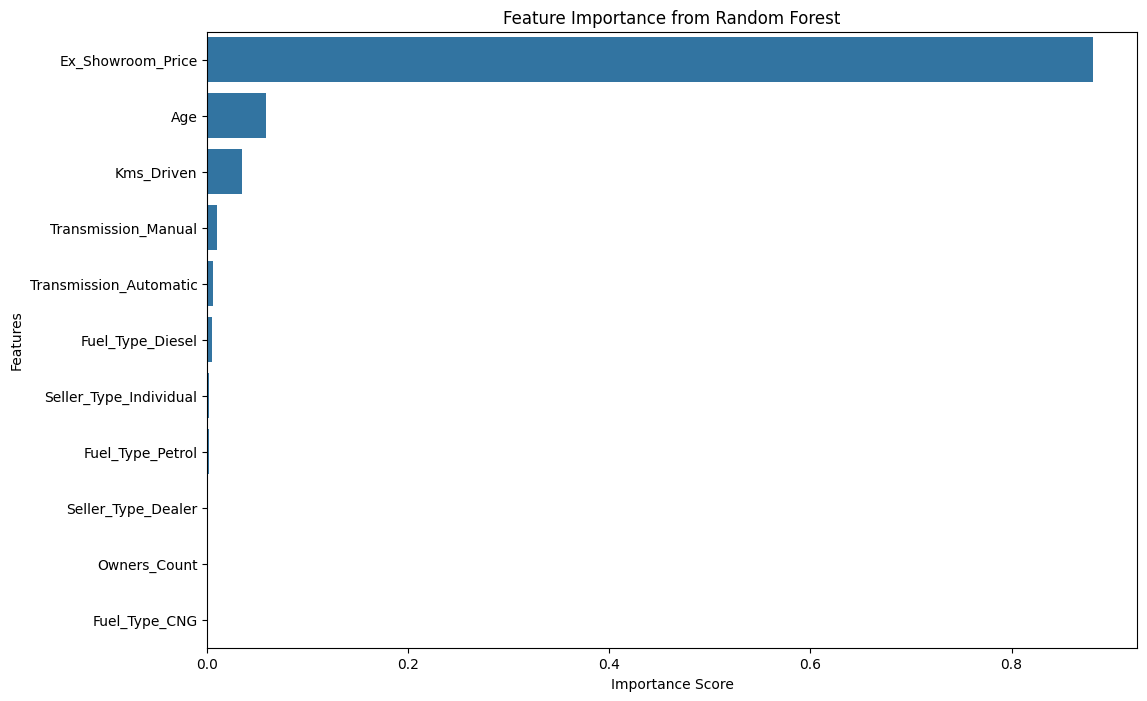

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset (update the file path or URL)
url = 'https://raw.githubusercontent.com/Pratyakshgupta887qwert/Shadowfox-internship-intermediate-tasks/refs/heads/Task2/car%20data%20(2).csv'
try:
    data = pd.read_csv(url)
    print("Dataset loaded successfully.")
except Exception as e:
    print("Error loading dataset:", e)
    raise

# Inspect dataset
print("\nDataset Overview:")
print(data.head())

# Create additional columns
data['Age'] = 2024 - data['Year']  # Compute age from the Year column
data.rename(columns={'Present_Price': 'Ex_Showroom_Price', 'Owner': 'Owners_Count'}, inplace=True)

# Define categorical and numerical features
categorical_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
numerical_features = ['Kms_Driven', 'Ex_Showroom_Price', 'Age', 'Owners_Count']
target = 'Selling_Price'

# Define features and target
X = data[categorical_features + numerical_features]
y = data[target]

# Handle missing values
if data.isnull().sum().sum() > 0:
    print("\nMissing values detected. Filling with mean/mode...")
    for column in X.columns:
        if X[column].dtype == 'object':
            X[column].fillna(X[column].mode()[0], inplace=True)
        else:
            X[column].fillna(X[column].mean(), inplace=True)

# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train and evaluate models
models = {'Random Forest': pipeline_rf, 'Linear Regression': pipeline_lr}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation metrics
    print(f"\n{model_name} Performance:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score:", r2_score(y_test, y_pred))

# Feature Importance Analysis (for Random Forest)
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importances = rf_model.named_steps['regressor'].feature_importances_
    feature_names = numerical_features + list(
        rf_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    )

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
    plt.title("Feature Importance from Random Forest")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()
